In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define functions

In [9]:
def generate_A(M, min_cells, max_cells):
    A_cols = []
    for m in range(M):
        n = np.random.randint(min_cells, max_cells)
        A_cols.append(np.ones(n))
    new_A_cols = []
    for r, row in enumerate(A_cols):
        if r == 0:
            zf = len(np.hstack(A_cols)) - len(row)
            new_A_cols.append(np.hstack([row, np.zeros(zf)]))
        else:
            zi = int(np.sum(new_A_cols))
            zf = len(np.hstack(A_cols)) - len(row) - zi
            new_A_cols.append(np.hstack([np.zeros(zi), row, np.zeros(zf)]))
    A = np.stack(new_A_cols)
    return A


def generate_C(A, probabilities):
    M, N = A.shape
    L = len(probabilities)
    C = np.zeros((M, L))
    for i in range(M):
        spot_indices = np.where(A[i] == 1)[0]
        cell_types = np.random.choice(L, size=len(spot_indices), p=probabilities)
        for j, cell_type in zip(spot_indices, cell_types):
            C[i, cell_type] += 1
    C[:, 0] += A.sum(axis=1) - C.sum(axis=1)
    return C


def generate_X(A, C):
    X = []
    for row_A, row_C in zip(A, C):
        row_X = np.copy(row_A)
        indices = np.where(row_A == 1)[0]
        row_X[indices] = np.repeat(np.arange(1, C.shape[1] + 1), row_C.astype(int))
        X.append(row_X)
    X_sparse = np.stack(X)
    X_sum = X_sparse.sum(axis=0)
    return X_sum, X_sparse


def generate_X_perm(X_sparse):
    X_sparse_perm = []
    for row_X in X_sparse:
        indices = np.where(row_X>0)[0]
        subrow_X = row_X[indices[0]:indices[-1]+1]
        np.random.shuffle(subrow_X)
        row_X[indices[0]:indices[-1]+1]=subrow_X
        X_sparse_perm.append(row_X)
    X_sparse_perm = np.stack(X_sparse_perm)
    X_perm = X_sparse_perm.sum(axis=0)
    return X_perm, X_sparse_perm


def generate_B(X, K, feature_overlap=1.0):
    N = len(X)
    B = np.zeros((N, K))
    for label in np.unique(X):
        for k in range(K):
            indices = np.where(X == label)[0]
            B[indices, k] = np.random.normal(label, feature_overlap, len(indices))
    scaler = StandardScaler()
    B = scaler.fit_transform(B)
    return B

def compute_stats(true_labels, predicted_labels, per_class=False):
    global_accuracy = accuracy_score(true_labels, predicted_labels)

    # Balanced accuracy
    balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

    # Weighted metrics
    weighted_f1 = f1_score(true_labels, predicted_labels, average="weighted", zero_division=0)
    weighted_precision = precision_score(true_labels, predicted_labels, average="weighted", zero_division=0)
    weighted_recall = recall_score(true_labels, predicted_labels, average="weighted", zero_division=0)

    metrics = {
        "Global Accuracy": global_accuracy,
        "Balanced Accuracy": balanced_acc,
        "Weighted F1 Score": weighted_f1,
        "Weighted Precision": weighted_precision,
        "Weighted Recall": weighted_recall,
    }

    if per_class:
        unique_classes = np.unique(true_labels)
        f1_per_class = f1_score(true_labels, predicted_labels, average=None, zero_division=0)
        precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
        recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)
        cm = confusion_matrix(true_labels, predicted_labels)

        metrics.update(
            {
                "F1 Score (Per Class)": dict(zip(unique_classes, f1_per_class)),
                "Precision (Per Class)": dict(zip(unique_classes, precision_per_class)),
                "Recall (Per Class)": dict(zip(unique_classes, recall_per_class)),
                "Confusion Matrix": pd.DataFrame(cm, columns=list(unique_classes), index=list(unique_classes)),
            }
        )
    
    return metrics

In [10]:
def plot_bags_in_grid(matrix_X, grid_size, seed, figsize):
    np.random.seed(seed)
    num_bags, num_instances = matrix_X.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    for bag_index in range(num_bags):
        bag_radius = 1 
        grid_row = bag_index // grid_size[1]
        grid_col = bag_index % grid_size[1]
        bag_center = (grid_col * 3, -grid_row * 3) 
        ax.add_patch(plt.Circle(bag_center, bag_radius, color='gray', alpha=0.3))
        instances_indices = np.where(matrix_X[bag_index] != 0)[0]
        if len(instances_indices) > 0:
            for instance_index in instances_indices:
                class_shapes = ['o', '^', 's', 'D']  
                class_colors = ['red', 'green', 'purple', 'blue'] 
                label = int(matrix_X[bag_index, instance_index]) % len(class_shapes)
                theta = 2 * np.pi * np.random.rand(1)
                radius = bag_radius * np.sqrt(np.random.rand(1))
                x = bag_center[0] + radius * np.cos(theta)/1.25
                y = bag_center[1] + radius * np.sin(theta)/1.25
                ax.scatter(x, y, marker=class_shapes[label], color=class_colors[label], s=75, edgecolors='black', alpha=.7)
    ax.set_aspect('equal', adjustable='datalim')
    return ax


# Simulate data
## Fully simulation

In [11]:
min_n,max_n = 2,9       # range of cells per spot
M = 13                  # number of spots
K = 15                  # number of features per cell
feature_overlap = 1.5   # feature overlap

In [12]:
# Three layer formation with proportion of cell types per layer
A_1 = generate_A(M, min_n,max_n)
C_1 = generate_C(A_1, np.array([0.6, 0.1, 0.2, 0.1]))

A_2 = generate_A(M, min_n,max_n)
C_2 = generate_C(A_2, np.array([0.1, 0.7, 0.1, 0.1]))

A_3 = generate_A(M, min_n,max_n)
C_3 = generate_C(A_3, np.array([0.3, 0.1, 0.5, 0.1]))

A = np.vstack([np.hstack([A_1,np.zeros(A_2.shape),np.zeros(A_3.shape)]),
           np.hstack([np.zeros(A_1.shape),A_2,np.zeros(A_3.shape)]),
           np.hstack([np.zeros(A_1.shape),np.zeros(A_2.shape),A_3])])
C = np.vstack([C_1,C_2,C_3])

# Generate cell types
X, X_sparse = generate_X(A,C)

# Generate permuted cell types
X_perm, X_sparse_perm = generate_X_perm(X_sparse.copy())

# Generate features per cell
B = generate_B(X, K, feature_overlap)

## Semi-simulation

In [13]:
import pandas as pd
import os
import json
import torch

data_path = '/cluster/CBIO/data1/lgortana/Xenium_FFPE_Human_Breast_Cancer_Rep1'

ground_truth = pd.read_csv(os.path.join(data_path, 'sim/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_gt.csv'), index_col=0)
embeddings = torch.load(os.path.join(data_path, 'sim/moco_embed_moco-XENHBrep1-rn50.pt'))
with open(os.path.join(data_path, f'sim/spot_dict_small.json'), "r") as file:
    spot_dict = json.load(file)

In [14]:
# 1. Unique sorted cell IDs across both spot_dict and ground_truth
cell_ids = sorted(set(ground_truth.index.astype(str)) & set(sum(spot_dict.values(), [])))
cell_id_to_idx = {cid: i for i, cid in enumerate(cell_ids)}
N = len(cell_ids)

In [15]:
# 2. Sorted spot IDs
spot_ids = sorted(spot_dict.keys())
spot_id_to_idx = {sid: i for i, sid in enumerate(spot_ids)}
M = len(spot_ids)

In [16]:
# 3. Map one-hot labels to class indices
cell_type_names = ground_truth.columns.tolist()
L = len(cell_type_names)
gt_labels = ground_truth.loc[ground_truth.index.astype(str).isin(cell_ids)]
label_array = gt_labels.to_numpy()
type_indices = label_array.argmax(axis=1) + 1 # get integer labels: 1, 2, ..., L

# Map cell_id → class index
cell_id_to_label = {
    str(cid): type_idx for cid, type_idx in zip(gt_labels.index.astype(str), type_indices)
}

In [17]:
# 4. B: Features per cell (N x K)
K = len(next(iter(embeddings.values())))  # 2048
B = np.zeros((N, K))

for i, cid in enumerate(cell_ids):
    if cid in embeddings:
        B[i] = embeddings[cid].detach().cpu().numpy()
    else:
        raise ValueError(f"Cell ID {cid} found in ground_truth or spot_dict but not in embeddings.")

In [18]:
# 5. A and X_sparse
A = np.zeros((M, N), dtype=int)
X_sparse = np.zeros((M, N), dtype=int)

for sid, cell_list in spot_dict.items():
    m = spot_id_to_idx[sid]
    for cid in cell_list:
        if cid in cell_id_to_idx and cid in cell_id_to_label:
            n = cell_id_to_idx[cid]
            A[m, n] = 1
            X_sparse[m, n] = cell_id_to_label[cid]

In [19]:
# 6. X: flat label vector (N,)
X = np.zeros(N, dtype=int)
for cid, n in cell_id_to_idx.items():
    if cid in cell_id_to_label:
        X[n] = cell_id_to_label[cid]

In [20]:
# 7. New organization of matrices

new_order = []
seen = set()

for row in X_sparse:
    cell_indices = np.where(row > 0)[0]
    for idx in cell_indices:
        if idx not in seen:
            new_order.append(idx)
            seen.add(idx)

X_sparse = X_sparse[:, new_order]
A = A[:, new_order]
B = B[new_order]
X = X[new_order]

X_perm, _ = generate_X_perm(X_sparse.copy())

### If you want to subset your data

In [21]:
# n_spots_to_keep = 60

# X_sparse = X_sparse[:n_spots_to_keep]
# A = A[:n_spots_to_keep]
# used_cell_indices = np.where(X_sparse.sum(axis=0) > 0)[0]

# X_sparse = X_sparse[:, used_cell_indices]
# A = A[:, used_cell_indices]
# X = X[used_cell_indices]
# B = B[used_cell_indices]

# X_perm, _ = generate_X_perm(X_sparse.copy())

### If you want to create batches

In [22]:
batch_size = 30

A_batches = []
B_batches = []
X_perm_batches = []

num_spots = A.shape[0]

for start in range(0, num_spots, batch_size):
    end = min(start + batch_size, num_spots)

    A_batch = A[start:end]
    used_cell_indices = np.where(A_batch.sum(axis=0) > 0)[0]

    A_batch = A_batch[:, used_cell_indices]
    B_batch = B[used_cell_indices]
    X_perm_batch = X_perm[used_cell_indices]

    A_batches.append(A_batch)
    B_batches.append(B_batch)
    X_perm_batches.append(X_perm_batch)

# Plot data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


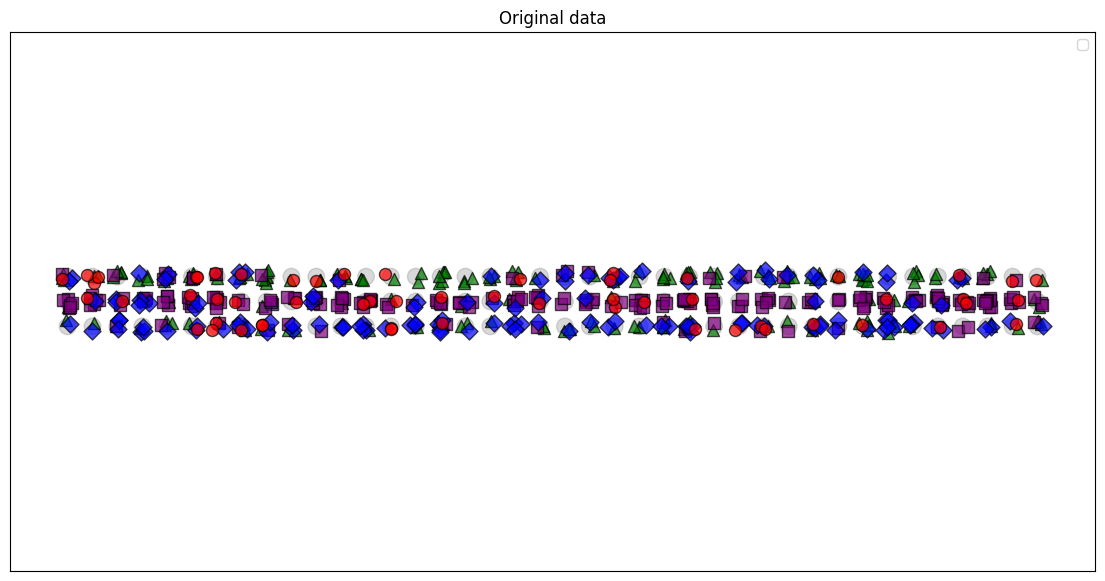

In [6]:
grid_size = (3, M)  # Rows and columns in the grid
ax = plot_bags_in_grid(X_sparse, grid_size, 0, (14,7))
ax.set_title('Original data')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

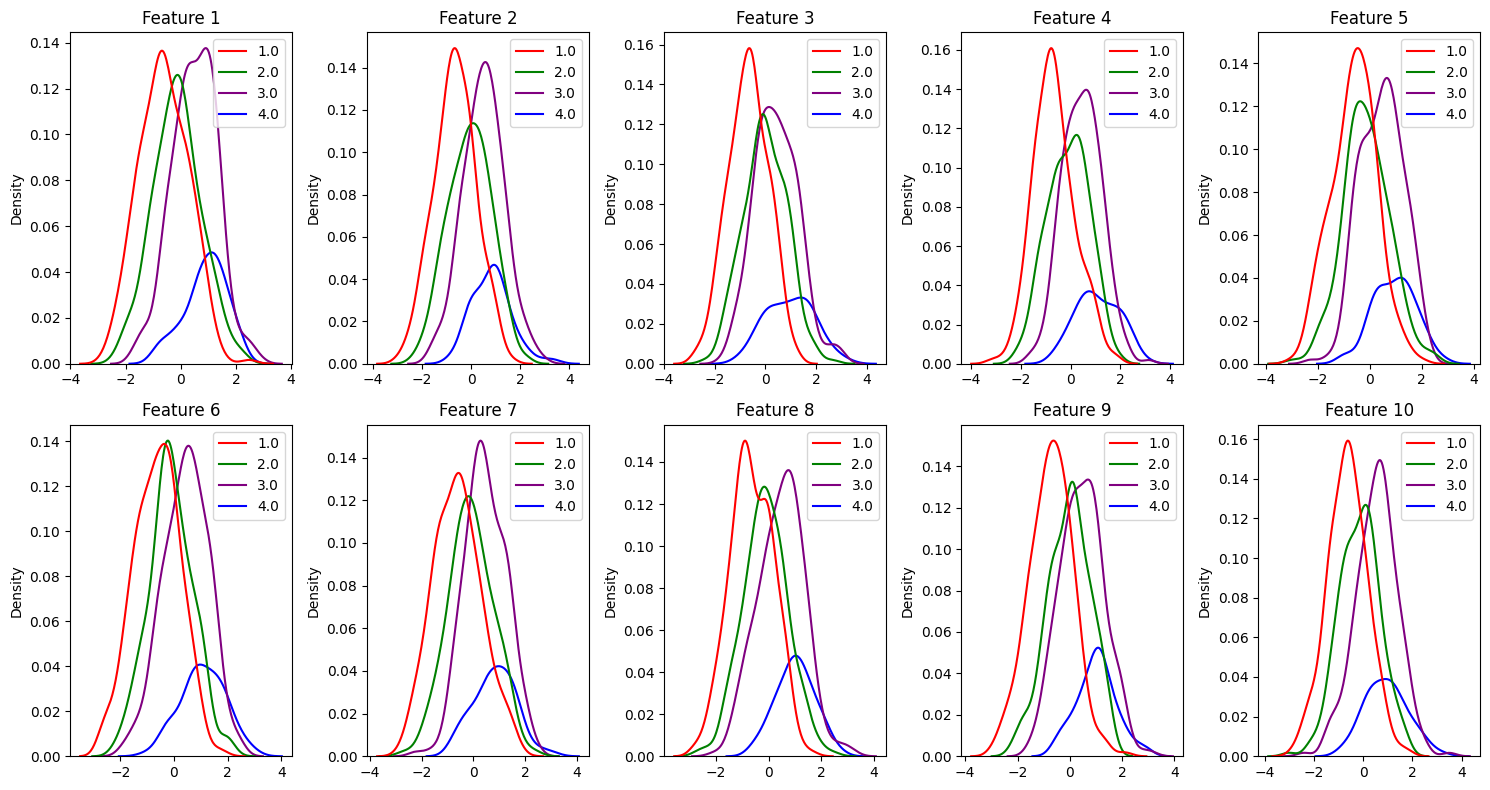

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()
for i in range(10):
    sns.kdeplot(x=B[:, i], hue=X, ax=axes[i], palette=['red','green', 'purple', 'blue'])
    axes[i].set_title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

# Run method

In [36]:
from celltype_permutation import hierarchical_permutations

## Run on an unique dataset

In [7]:
X_global = hierarchical_permutations(A, X_perm, B)

--------------------------------------------------------------
M_spot	 Perm_1	 	 Perm_2	 CHI
--------------------------------------------------------------
0 	 1680 		 1 	 2.5831802771849084
1 	 5 		 1 	 5.94516245292315
2 	 6 		 1 	 4.06722907368647
3 	 10 		 1 	 3.156726324046038
4 	 1 		 1 	 -inf
5 	 2 		 2 	 -inf
6 	 60 		 6 	 6.134094473022643
7 	 210 		 2 	 2.9827610101262554
8 	 1 		 1 	 -inf
9 	 3 		 1 	 1.5998426589625212
10 	 3 		 1 	 1.4722862429453556
11 	 1 		 1 	 -inf
12 	 3 		 1 	 6.384884982974709
13 	 1 		 1 	 -inf
14 	 1 		 1 	 -inf
15 	 7 		 1 	 1.359875729034059
16 	 1 		 1 	 -inf
17 	 60 		 1 	 2.642274064565919
18 	 30 		 2 	 2.5858268670584494
19 	 4 		 1 	 3.2304017926824304
20 	 6 		 1 	 3.5212569775614684
21 	 1 		 1 	 -inf
22 	 420 		 1 	 2.3161515575066898
23 	 4 		 1 	 3.809068934047668
24 	 4 		 1 	 1.7073109152328179
25 	 1 		 1 	 -inf
26 	 4 		 1 	 2.6610570488006045
27 	 420 		 2 	 3.091583723662381
28 	 105 		 1 	 1.9086245773181656
29 	 20 		 2 	 2.38

100%|██████████| 12288/12288 [00:02<00:00, 4662.64it/s]

Maximum Score: 11.955831104106245
Total time: 3.8398115634918213


## Run on a batched dataset

In [37]:
X_global_batches = []
i = 0
for A_batch, X_perm_batch, B_batch in zip(A_batches, X_perm_batches, B_batches):
    print(f'Processing batch {i+1}/{len(A_batches)}')
    X_global_batch = hierarchical_permutations(A_batch, X_perm_batch, B_batch)
    X_global_batches.append(X_global_batch)
    i += 1

X_global = np.concatenate(X_global_batches)

Processing batch 1/262


100%|██████████| 20736/20736 [00:16<00:00, 1222.62it/s]


Maximum Score: 2.790050881904699
Total time: 17.15635108947754
Processing batch 2/262


100%|██████████| 82944/82944 [01:09<00:00, 1188.05it/s]


Maximum Score: 2.4833577612479534
Total time: 69.95217156410217
Processing batch 3/262


100%|██████████| 576/576 [00:00<00:00, 1269.44it/s]


Maximum Score: 4.141475305780741
Total time: 0.494945764541626
Processing batch 4/262


100%|██████████| 576/576 [00:00<00:00, 1223.14it/s]


Maximum Score: 2.616516118163141
Total time: 0.558661699295044
Processing batch 5/262


100%|██████████| 8/8 [00:00<00:00, 1157.57it/s]


Maximum Score: 2.335247740579214
Total time: 0.02606511116027832
Processing batch 6/262


100%|██████████| 864/864 [00:00<00:00, 1319.64it/s]


Maximum Score: 3.692910310015876
Total time: 0.7791774272918701
Processing batch 7/262


100%|██████████| 5184/5184 [00:04<00:00, 1266.17it/s]


Maximum Score: 2.5531174344058343
Total time: 4.125540018081665
Processing batch 8/262


100%|██████████| 2/2 [00:00<00:00, 934.14it/s]


Maximum Score: 3.4153917391389466
Total time: 0.3497188091278076
Processing batch 9/262


100%|██████████| 32/32 [00:00<00:00, 1233.87it/s]


Maximum Score: 2.2674060520852666
Total time: 0.04580569267272949
Processing batch 10/262


100%|██████████| 221184/221184 [02:48<00:00, 1310.59it/s]


Maximum Score: 3.3991039000766152
Total time: 169.2788417339325
Processing batch 11/262


100%|██████████| 2304/2304 [00:01<00:00, 1301.56it/s]


Maximum Score: 3.1711709929919736
Total time: 1.844928503036499
Processing batch 12/262


100%|██████████| 480/480 [00:00<00:00, 1241.02it/s]


Maximum Score: 1.5336192421987125
Total time: 0.41832494735717773
Processing batch 13/262


100%|██████████| 1536/1536 [00:01<00:00, 1259.50it/s]


Maximum Score: 3.613142972985571
Total time: 1.5242938995361328
Processing batch 14/262


100%|██████████| 48/48 [00:00<00:00, 1081.60it/s]


Maximum Score: 1.1558093414749884
Total time: 0.06289482116699219
Processing batch 15/262


  0%|          | 32854/11943936 [00:25<2:31:13, 1312.77it/s]


KeyboardInterrupt: 

## Evaluate results

In [ ]:
metrics_before = compute_stats(X, X_perm, per_class=True)
metrics_after = compute_stats(X, X_global, per_class=True)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('BEFORE')
print(classification_report(X, X_perm))

BEFORE
              precision    recall  f1-score   support

           1       0.85      0.85      0.85        67
           2       0.12      0.12      0.12         8
           3       0.47      0.47      0.47        19
           4       0.47      0.47      0.47        19
           5       0.38      0.38      0.38        16
           6       0.53      0.53      0.53        15

    accuracy                           0.62       144
   macro avg       0.47      0.47      0.47       144
weighted avg       0.62      0.62      0.62       144



In [ ]:
print('AFTER')
print(classification_report(X, X_global))

AFTER
              precision    recall  f1-score   support

           1       0.91      0.91      0.91        67
           2       0.75      0.75      0.75         8
           3       0.53      0.53      0.53        19
           4       0.68      0.68      0.68        19
           5       0.69      0.69      0.69        16
           6       0.40      0.40      0.40        15

    accuracy                           0.74       144
   macro avg       0.66      0.66      0.66       144
weighted avg       0.74      0.74      0.74       144

